<b>COSMIC RADIATION: K-Nearest Neighbours from scratch</b>
    
rodrigoX: Contains 4 parameters
    1. NALLParticlesTotal : Total number of particles generated by the event in the ground level.
    2. MUTotal : Total number of muons.
    3. ELTotal : Total number of electromagnetic particles.
    4. Zenith : Zenith angle of the particle [degrees].
    5. Energy : Particle energy [GeV].

rodrigoY: contains the target
    Labels: photon, proton, helium, nitrogen, iron.
        the smallest number is assigned to photon (A=0) and the highest number to the heaviest particle, this is, iron (B=4).
        
        0==photon     1==proton    2==helium     3==nitrogen   4==iron 
     

In [1]:

import pandas as pd
import numpy as np
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
class KNN:  #Only using numpy
    def __init__(self, X_train, X_test, y_train,K,distance):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.K=K
        self.distance=distance
        
    def distancia (self,a,b,option): #This function only works with numpy arrays, not scalars
        #a distance that gives more importance to points in a group can be tried to avoid outliers
        if option=='euclidea':
            d=a-b
            dist=np.sqrt(np.sum(d*d, axis=1))
        elif option=='manhattan':
            d=a-b
            dist=np.sum(np.absolute(d),axis=1)
        return dist


    def KNN_np(self) :   

            y_prueba=np.zeros(len(self.X_test)) #array where predictions are
            distancias= np.zeros(shape=(len(self.X_train))) #array where distances are
            for j in range (len(self.X_test)):

                posicion=np.array(self.X_test[j,:]) #for each j belonging to X_test
                distancias=KNN.distancia(self,posicion,self.X_train,self.distance)

                #I modify it by adding indexes, to know the category of each x-train
                indice=np.arange(0, len(self.X_train))
                distancias=np.array([distancias,indice]).T

                #I order the list (descending) and choose the first k-colums
                distancias=distancias[distancias[:,0].argsort()] #I order it by first colum (or row) such that I know the positions of x-train 
                distancias=distancias[0:self.K,:]                                        #they are the ones with the shortest distance

                #I split distances and its respective classes
                indice_clases=np.array(distancias[:,1:2],dtype=np.int64)
                dist=distancias[:,0:1]

                clases= np.zeros(shape=(len(indice_clases)))
                for i in range(self.K):
                    clases[i]=self.y_train[indice_clases[i]]

                #See the most frequent class
                mode = Counter(clases).most_common()# if in the patenthesis a 1 is written, it gives the most common. If a 2, the 2 most common etc.
                pred=mode[0][0]
                if  (len(mode)>1) and (mode[0][0]==mode[1][1]): #If any class ir repeated the same number of times,I choose the class belonging to the closest point
                    pred=clases[0]

                y_prueba[j]=pred
            return y_prueba
    
    def error(y_prueba,y_test):
        #Calculate the error 
        error=np.zeros(len(y_test))

        #If the class is not the same, the error is 1, otherwise 0.
        for i in range(len(y_test)):
            if y_test[i]==y_prueba[i]:
                error[i]=0
            else:
                error[i]=1
                      
        error_total=np.sum(error)/len(y_test)
        return (1-error_total)

    def split_scale(X,y,train_perc):
        #reescale the data (substract mean and divide by std)
        train_size=int(train_perc*X.shape[0])
        test_size=X.shape[0]-train_size

        X_train=X[0:train_size]
        y_train=y[0:train_size]
        X_test=X[train_size:X.shape[0]]
        y_test=y[train_size:X.shape[0]]
        #X_train
        mean, std = X_train.mean(), X_train.std()
        X_train= (X_train-mean)/std
        max_X_train=X_train.max()
        min_X_train=X_train.min()
        X_train=(X_train-min_X_train)/(max_X_train-min_X_train)
        #X_test
        X_test= (X_test-mean)/std
        max_X_test=X_test.max()
        min_X_test=X_test.min()
        X_test=(X_test-min_X_test)/(max_X_test-min_X_test)
        return X_train,X_test,y_train,y_test
    def cv(partes,X_train,y_train,krange_inf,krange_sup,choice):
        #cross-validation for a certain range of k
        split_x=np.array_split(X_train, partes) 
        split_y=np.array_split(y_train, partes) 

        #I put in a list df with splits, and later I transform it to numpy arrays
        lists_x = [ [] for i in range(partes) ] #Create a list to put each L-fold
        lists_y = [ [] for i in range(partes) ] 

        for i in range(partes): #Put each L-fold in the lists to work on them 
            lists_x[i]=split_x[i].values.tolist()
            lists_y[i]=split_y[i].values.tolist()
        optimo=np.empty((krange_sup-krange_inf))# stores the accuracy of each k
        contador=0
        for p in range(krange_inf,krange_sup): #for each value of k
            print('loop numero ',p)
            errores=np.empty((partes)) #store the predicction of each subset, to do the mean later
            for j in range(partes): #to obtain each subset x-train, y-train from the - fold
                if j!=0:
                    X_train_cv=np.array(np.array(lists_x)[0])
                    y_train_cv=np.array(np.array(lists_y)[0])
                    for i in range(1,partes):
                        if i!=(j):
                            #print('valor de i: ',i,', shape x_train: ',X_train_cv.shape)
                            X_train_cv=np.concatenate( ( X_train_cv, np.array(np.array(lists_x)[i]) ) , axis=0)
                            y_train_cv=np.concatenate( ( y_train_cv, np.array(np.array(lists_y)[i]) ) , axis=0)
                else:
                    X_train_cv=np.array(np.array(lists_x)[1])
                    y_train_cv=np.array(np.array(lists_y)[1])
                    for i in range(2,partes):
                        X_train_cv=np.concatenate( ( X_train_cv, np.array(np.array(lists_x)[i]) ) , axis=0)
                        y_train_cv=np.concatenate( ( y_train_cv, np.array(np.array(lists_y)[i]) ) , axis=0)

                X_test_cv=np.array(np.array(lists_x)[j]) #subset x-test, y-test from the l-fold
                y_test_cv=np.array(np.array(lists_y)[j])
                #Already have x-train, x-test, y-train. Now I test them
                
                testeo=KNN(X_train_cv, X_test_cv, y_train_cv,p,choice)
                y_pred_2=testeo.KNN_np()
                
                #evaluo el error
                errores[j]=error(y_pred_2,y_test_cv) 
            optimo[contador]=errores.mean()
            contador=contador+1
        indices = np.where(optimo == optimo.max()) #I see the most accurate k
        k_optimo= krange_inf+np.array(indices)

        return optimo, k_optimo
    


In [3]:
#leave the dataset ready
df_x = pd.read_fwf('XRodrigo.txt')
df_x.columns = ["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]
df_y=pd.read_fwf('YRodrigo.txt')
df_y.columns = ["Particle"]

transpose=df_x.T
transpose_y=df_y.T #Transpose to put them together
df_tot = transpose.append(transpose_y)
df_tot=df_tot.T.sample(frac=1).reset_index(drop=True)#this is the final df complete and shuffled

df_y=df_tot[['Particle']]
df_x=df_tot[["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]]

In [4]:
#DIVIDE THE DATAFRAME IN TRAIN AND TEST AND REESCALE IT
X_train,X_test,y_train,y_test=KNN.split_scale(df_x,df_y,0.75)

#convert to numpy
X_train_np=X_train.to_numpy()  
X_test_np=X_test.to_numpy()  
y_train_np=y_train.to_numpy()
y_test_np=y_test.to_numpy() 


In [1]:
#hago cross-validation
optimo, k_optimo=KNN.cv(10,X_train,y_train,7,8,'euclidea')

In [2]:
#check the best k
k_optimo

In [12]:
#Test the best k 
testeo=KNN(X_train_np, X_test_np, y_train_np,1,'euclidea')
y_prueba=testeo.KNN_np()

In [15]:
#Check its accuracy
y_prueba_np=np.array(y_prueba)
y_test_np=y_test.to_numpy().reshape(len(y_test)) #lo pongo tal que tenga la misma forma que y_prueba
acierto=KNN.error(y_prueba,y_test_np) 
acierto

0.7365212421413603

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_prueba,y_test_np))
print(classification_report(y_prueba,y_test_np))

[[2092    3    5    5    4]
 [  57 1523  248   48   24]
 [  16  405 1268  475   83]
 [   8   78  483 1302  409]
 [   1   22   35  291 1613]]
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      2109
         1.0       0.75      0.80      0.77      1900
         2.0       0.62      0.56      0.59      2247
         3.0       0.61      0.57      0.59      2280
         4.0       0.76      0.82      0.79      1962

    accuracy                           0.74     10498
   macro avg       0.74      0.75      0.74     10498
weighted avg       0.74      0.74      0.74     10498



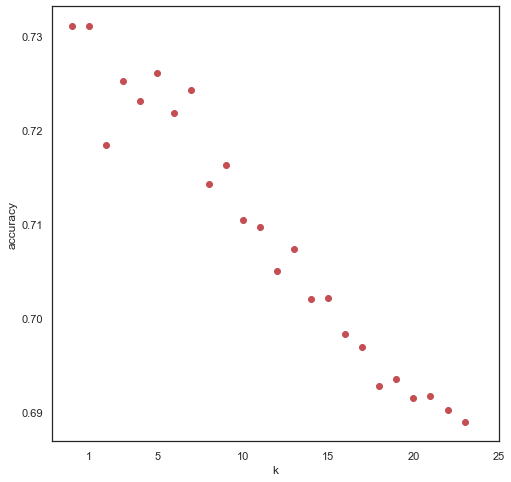

<Figure size 576x576 with 0 Axes>

In [113]:
#plot for k from CV, range from 1 to 24
k_values_cv=[0.73108288, 0.73108288, 0.7184131 , 0.72520824, 0.7231127,0.7260977 , 0.721811  , 0.72428782, 0.71431701, 0.71628555,0.71047494, 0.70971309, 0.7050769 , 0.70739503, 0.7020604 ,0.70221904, 0.69831329, 0.69697978, 0.69278852, 0.69355065,0.69151834, 0.69180442, 0.69024824, 0.68904183]
plt.plot(k_values_cv,'ro')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.xticks([1,5,10,15,20,25])
plt.show()
plt.savefig("accuracy_vs_k.png")

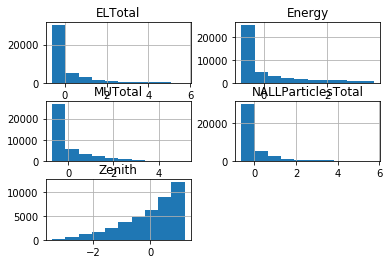

In [6]:
df_x.hist()
plt.show()

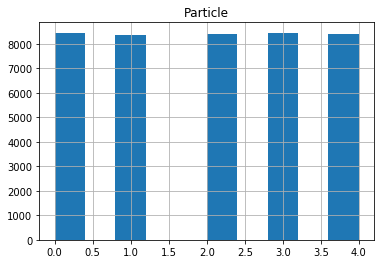

In [7]:
df_y.hist()
plt.show()

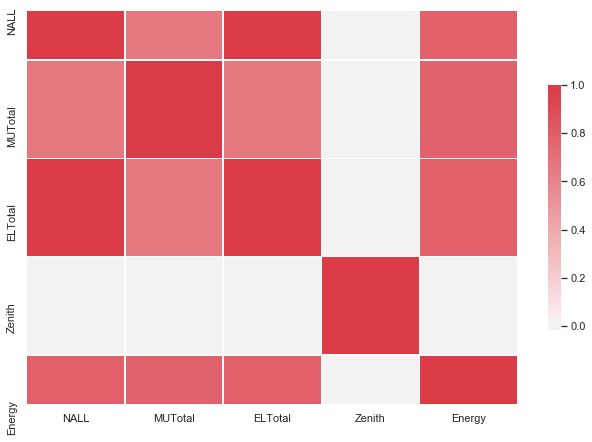

In [45]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))
d=df_x.copy()
d=d.rename(columns={"NALLParticlesTotal": "NALL"})
# Compute the correlation matrix
corr = d.corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

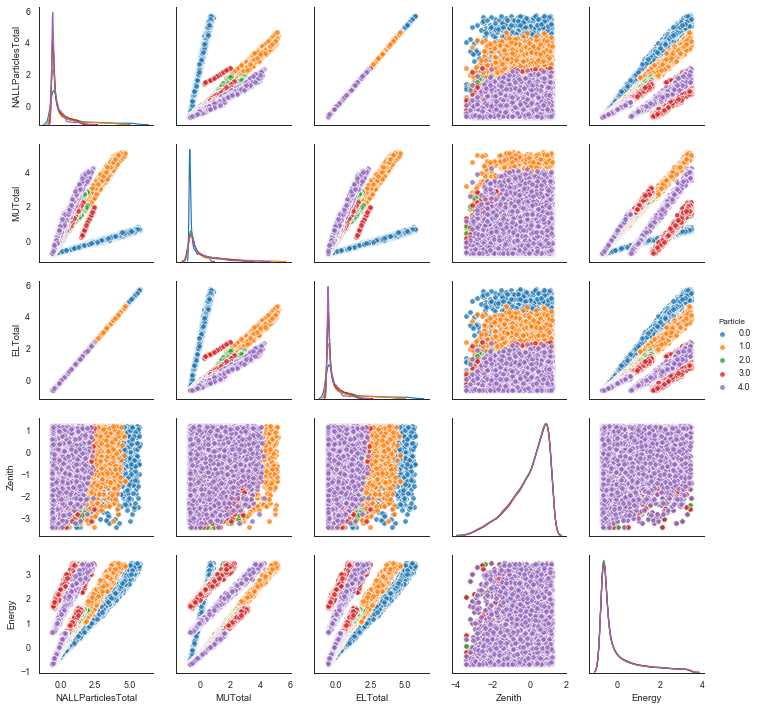

In [6]:
#sns.set_style("whitegrid")#to choose grid
#sns.pairplot(df_tot, hue = 'Particle', diag_kind = 'kde',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4)
# Title
sns.set_style("white")
sns.set_context("paper")
vars = ["NALLParticlesTotal", "MUTotal", "ELTotal", "Zenith","Energy"]
sns.pairplot(df_tot, hue = 'Particle', vars=vars, height=2, diag_kind = 'kde',
             plot_kws = {'alpha': 0.8, 's': 30, 'edgecolor': 'w'},
             diag_kws=dict(shade=False)    )

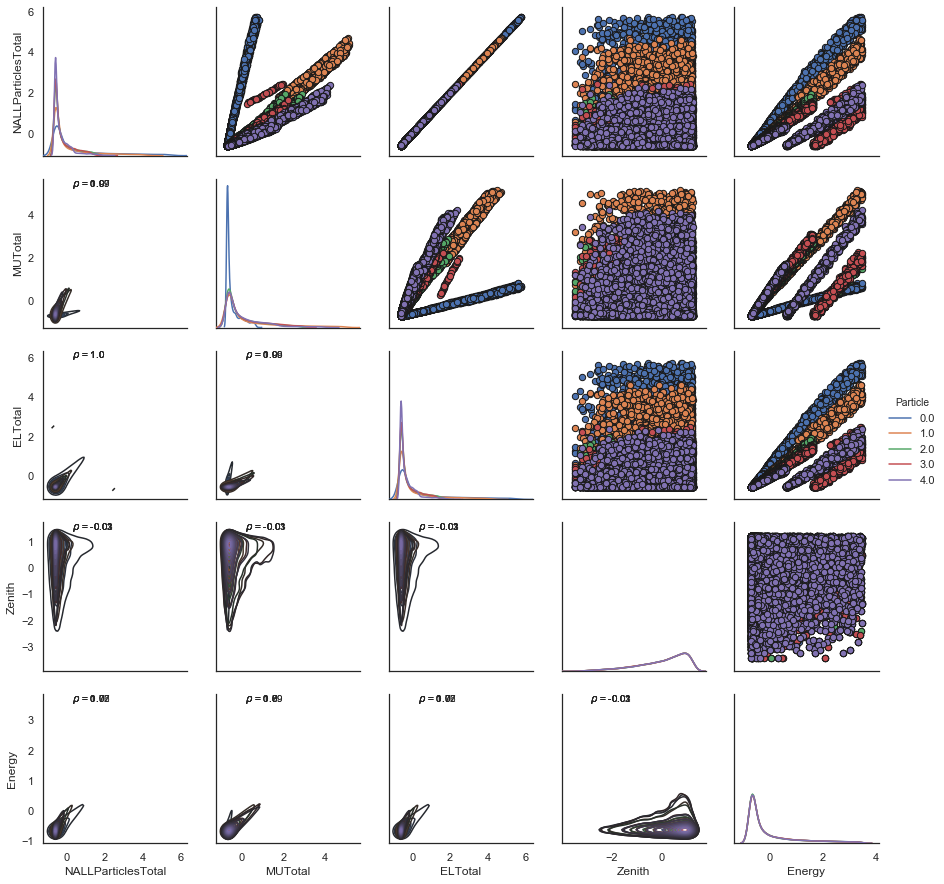

In [110]:
#https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("white")
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 10, xycoords = ax.transAxes)

g = sns.PairGrid(df_tot, hue="Particle",vars=vars)
g = g.map_diag(sns.kdeplot)
g = g.map_upper(plt.scatter,edgecolor="k", s=40)
g = g.map_lower(corr)
g = g.map_lower(sns.kdeplot)
g = g.add_legend()

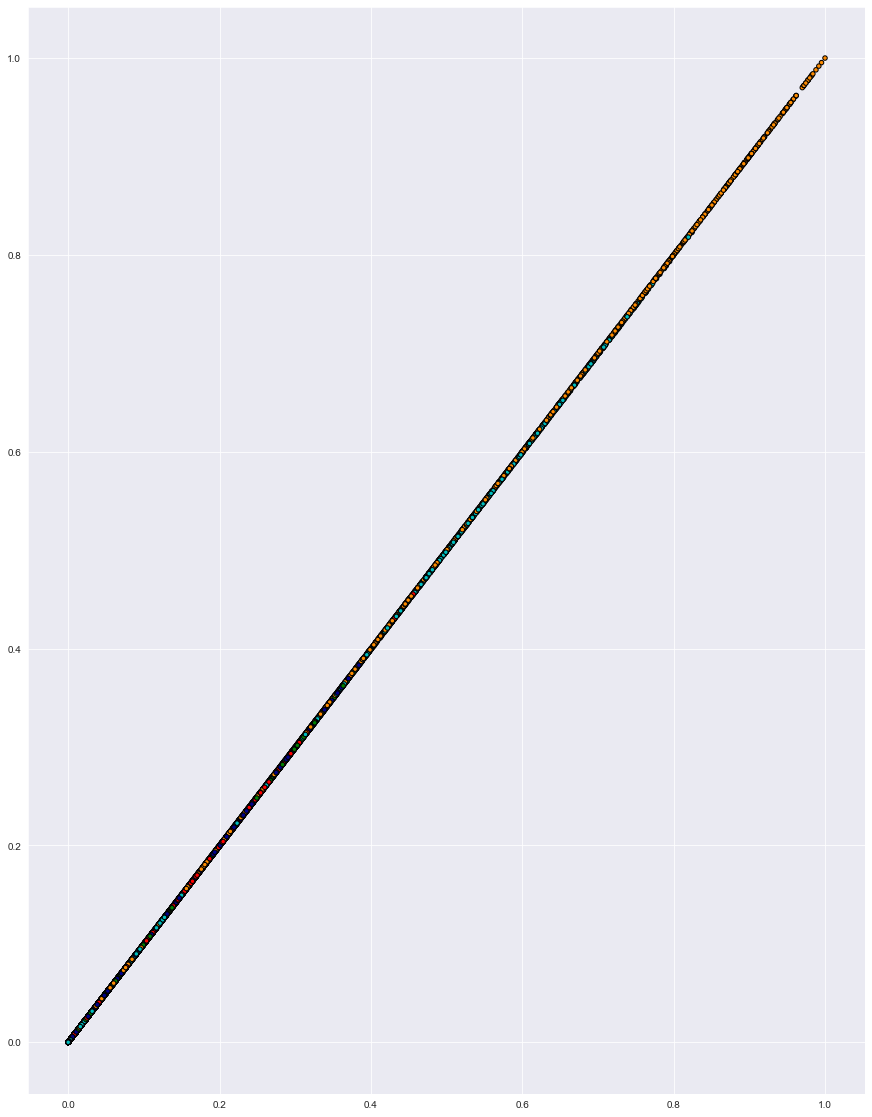

In [40]:
X = X_train_np[:,[0,2]] #choose the columns to plot
y = y_train_np.astype(int).reshape(len(y_train_np))
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue', 'darkred', 'darkgreen'])
cmap_bold = ListedColormap(['darkorange', 'c','darkblue','red', 'green'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,edgecolor='k', s=20)

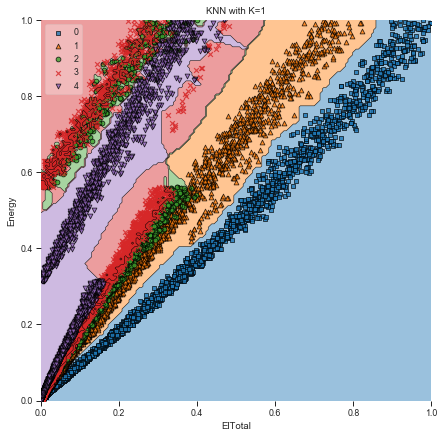

In [8]:
k=1

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsClassifier
def knn_comparison(X_,y_, k): #numpy arrays
 x = X_[:,[2,4]] #I choose the colums to be represented
 y = y_.astype(int).reshape(len(y_train_np))
 clf = neighbors.KNeighborsClassifier(n_neighbors=k)
 clf.fit(x, y)
# Plotting decision region
 plot_decision_regions(x, y, clf=clf, legend=2)
# Adding axes annotations
 plt.xlabel('ElTotal')
 plt.ylabel('Energy')
 plt.title('KNN with K='+ str(k))
 plt.xlim(0,1)
 plt.ylim(0, 1)
 plt.show()

knn_comparison(X_train_np,y_train_np,k)